# Procesamiento de Imágenes - Trabajo Práctico N°5
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

# Ejercicio 1 - Inverse Filtering
En esta notebook se muestra el uso del filtrado inverso para poder reconstruir la información de una imagen distorsionada.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
def plot_images(original, modified, label):
    fig, ax = plt.subplots(1, 2, figsize=(10,10))
    ax[0].set_title('Original', fontsize=15)
    ax[0].imshow(np.abs(original), cmap='gray')
    ax[1].set_title(label, fontsize=15)
    ax[1].imshow(np.abs(modified), cmap='gray')

## a. Blur
Se trabaja con la imagen *lenagray.tif*, que se muestra a continuación.

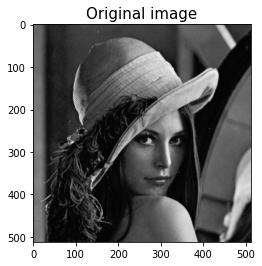

In [17]:
# Open image
img = np.array(Image.open('../../assets/lenagray.tif').convert('L'))

# Plot image
plt.title('Original image', fontsize=15)
plt.imshow(img, cmap='gray');

Para generar la distorsión de la imagen, se le aplica un filtro pasabajos $h(x,y)$ usando FFT. La ganancia del filtro (en veces) no puede ser nula en ningún punto, de forma tal de poder calcular su inversa para la recuperación de la imagen.

<div style="text-align:center"><img src="../../assets/ej1/blur.png" width="600">

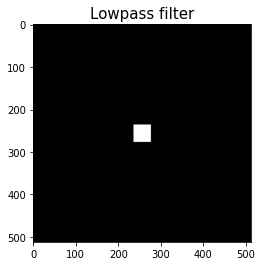

In [18]:
# Generate low-pass filter to distort image
cutoff = 20
stopband_gain = 0.1
lpf = np.full((np.array(img).shape), stopband_gain)
lpf[(lpf.shape[0] // 2) - cutoff: (lpf.shape[0] // 2) + cutoff + 1, (lpf.shape[1] // 2) - cutoff:(lpf.shape[1] // 2) + cutoff + 1] = 1
plt.imshow(np.abs(lpf), cmap='gray')
plt.title('Lowpass filter', fontsize=15)
plt.show()

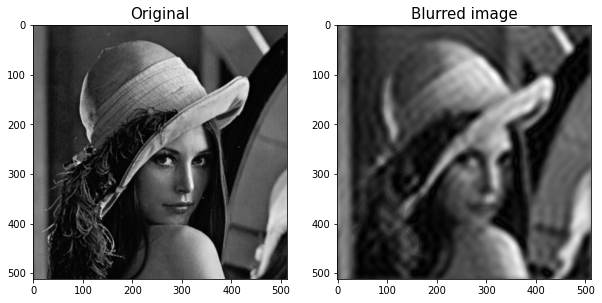

In [21]:
# Blur image
blurred_img =np.fft.ifft2(np.fft.fftshift(np.fft.fft2(img)) * lpf)
plot_images(img, blurred_img, 'Blurred image')

In [20]:
def mse(_x,_y):
    x = np.array(_x)
    y = np.array(_y)
    if x.shape != y.shape:
        raise ValueError('[MSE] x and y dimension must be the same!')
    return np.power((x-y), 2).sum() / x.size

Dado que se conoce la función transferencia de la distorsión, puede calcularse su inversa y aplicarse a la imagen distorsionada. Como resultado se obtiene la imagen original.

$$ G(\omega_1, \omega_2) = H(\omega_1, \omega_2) \cdot F(\omega_1, \omega_2) $$

$$ H^{-1}(\omega_1, \omega_2)\cdot \left[G(\omega_1, \omega_2) \right]= H^{-1}(\omega_1, \omega_2)\cdot \left[H(\omega_1, \omega_2) \cdot F(\omega_1, \omega_2) \right]$$

$$ H^{-1}(\omega_1, \omega_2)\cdot G(\omega_1, \omega_2) =  F(\omega_1, \omega_2)$$

De esta forma, idealmente no debería existir error en este método.


MSE = 8.063535795042085e-26


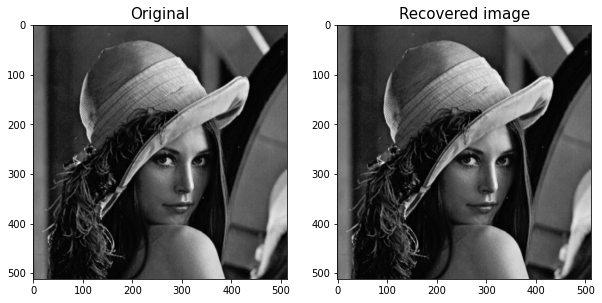

In [22]:
# Inverse filtering
rec_img = np.fft.ifft2(np.fft.fft2(blurred_img) / lpf)
plot_images(img, rec_img, 'Recovered image')
print(f'MSE = {mse(img, np.abs(rec_img))}')

En este caso, se obtiene un MSE despreciable que puede ser atribuido a operaciones de redondeo. Luego, se considera MSE nulo. Esto se condice con la teoría, dado que el producto de ambas transformaciones es 1, no afectando a la imagen en su totalidad.

## b. Blur + Noise

En segundo lugar, se repite el procedimiento realizado en el apartado anterior pero se agrega ruido blanco gaussiano previo a aplicar la transformación inversa.

<div style="text-align:center"><img src="../../assets/ej1/blur_noise.png" width="600">

Para definir la potencia del ruido aditivo se usa el SNR, tomando como referencia la potencia de la imagen original. Para evaluar el resultado se usa nuevamente el MSE.

noise variance = 16.99


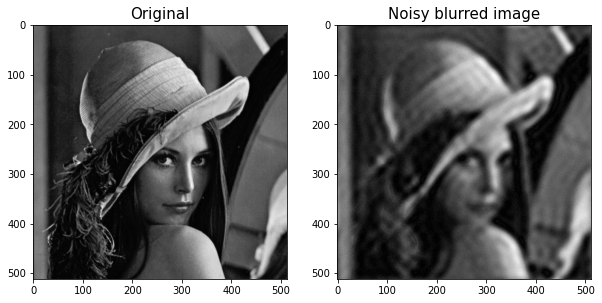

In [50]:
snr = 80

# Generate noise
img_power = np.power(np.abs(blurred_img),2).sum()
noise_power = img_power / (10**(0.1*snr))
print(f'noise variance = {noise_power:.2f}')

# Add noise to image
noisy_blurred_img = np.clip(np.abs(blurred_img) + np.random.normal(0,np.sqrt(noise_power), img.shape), 0, 255)

# Plot images
plot_images(img, noisy_blurred_img, 'Noisy blurred image')

Planteando las ecuaciones al igual que en el caso anterior,


$$ G(\omega_1, \omega_2) = H(\omega_1, \omega_2) \cdot F(\omega_1, \omega_2) + N(\omega_1, \omega_2) $$

$$ H^{-1}(\omega_1, \omega_2)\cdot \left[G(\omega_1, \omega_2) \right]= H^{-1}(\omega_1, \omega_2)\cdot \left[H(\omega_1, \omega_2) \cdot F(\omega_1, \omega_2)  + N(\omega_1, \omega_2) \right]$$

$$ H^{-1}(\omega_1, \omega_2)\cdot G(\omega_1, \omega_2) =  F(\omega_1, \omega_2) +  H^{-1}(\omega_1, \omega_2) \cdot N(\omega_1, \omega_2)$$

Luego, se aprecia que sobrevive el término $H^{-1}(\omega_1, \omega_2) \cdot N(\omega_1, \omega_2)$ en la imagen recuperada. Luego, el error no será nulo. Si la transferencia presenta valores muy bajos para alguna componente de frecuencia, luego el ruido en la imagen recueperada se verá amplificado en esa banda. Este efecto no es deseable y aumenta el error.

MSE = 1466.7644310705932


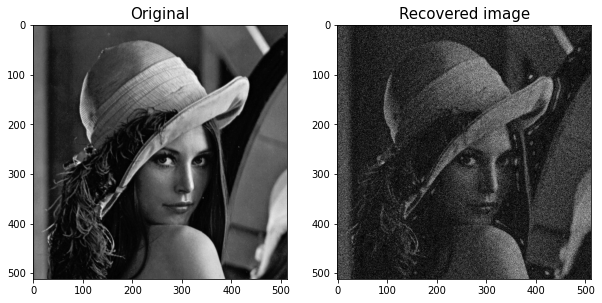

In [51]:
# Recover blur + noise image using inverse transformation
rec_noisy_img = np.fft.ifft2(np.fft.fftshift(np.fft.fft2(noisy_blurred_img)) / lpf)
plot_images(img, rec_noisy_img, 'Recovered image')
print(f'MSE = {mse(img, np.abs(rec_noisy_img))}')

Se observa que con un SNR de $80dB$, la reconstrucción de la imagen tiene un error apreciable comparada con la reconstrucción sin la adición de ruido. A continuación, se realiza un gráfico que muestra la evolución del error cuadrático medio de la reconstrucción en función de la potencia de ruido introducida en la imagen.

In [46]:
mse_array = []
snr_array = np.arange(150)
for i in snr_array:
    # Add noise to blurred image
    img_power = np.power(np.abs(blurred_img),2).sum()
    noise_power = img_power / (10**(0.1*i))
    noisy_blurred_img = np.clip(np.abs(blurred_img) + np.random.normal(0,np.sqrt(noise_power), img.shape), 0, 255)
    
    # Recover image
    rec_noisy_img = np.fft.ifft2(np.fft.fftshift(np.fft.fft2(noisy_blurred_img)) / lpf)
    mse_array.append(mse(img, np.abs(rec_noisy_img)))

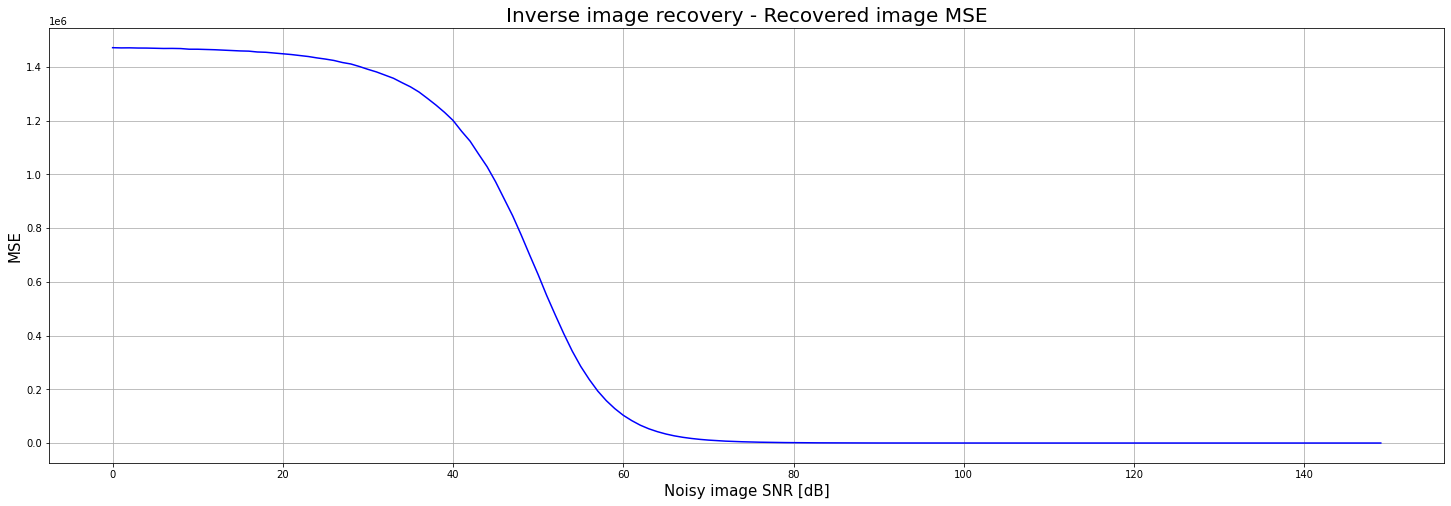

In [54]:
plt.figure(figsize=(25,8))
plt.title('Inverse image recovery - Recovered image MSE', fontsize=20)
plt.xlabel('Noisy image SNR [dB]', fontsize=15)
plt.ylabel('MSE', fontsize=15)
plt.grid(which='both', axis='both')
plt.plot(snr_array, mse_array, color='blue')
plt.show()

En el gráfico anterior se muestra como para valores bajos de SNR la recuperación de la imagen por la inversa de la distorsión tiene un alto error. A medida que disminuye la potencia del ruido, el MSE de la imagen resultante disminuye hasta ser asintótico.